In [1]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [2]:
img_shape = 256
batch_size = 4
num_classes = 32

In [3]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_upsa1 = UpSampling2D(2, interpolation="bilinear")(block4_conv3)

    block5_conc1 = Concatenate()([block3_conv3, block4_upsa1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_upsa1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_upsa1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)
    
    block8_output = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

model = get_model(img_shape, num_classes)

In [4]:
model.load_weights("last_w.h5")

In [20]:
img = imread("/home/rv/room1.jpg")
#seg = imread('data/ADE20K_formated/val/mask/mask/00000304.png')
img = cv2.resize(img, (img_shape, img_shape)) / 255
#seg = cv2.resize(seg, (img_shape, img_shape), interpolation = cv2.INTER_NEAREST) 
#seg = to_categorical(seg, num_classes=32)

In [21]:
%%time


CPU times: user 63.5 ms, sys: 20.8 ms, total: 84.4 ms
Wall time: 76.1 ms


In [5]:
objects = []
with open("data/ADE20K_filtred/class_old_new_filt.csv") as f:
    for line in f:
        objects.append(line.split(";")[0])

In [10]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(32):
        mask = pred[:, :, i]
        print(np.sum(mask) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray", norm=None)
        
        plt.title(objects[i])
        plt.show()
    return pred
        

0.760808527469635


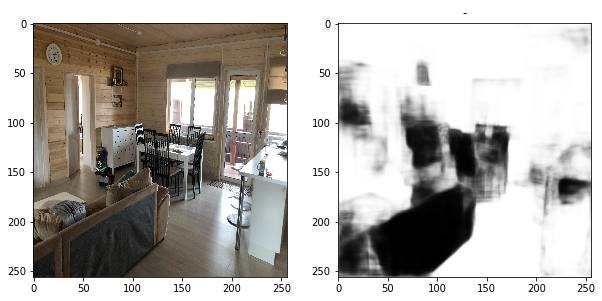

0.03016071394085884


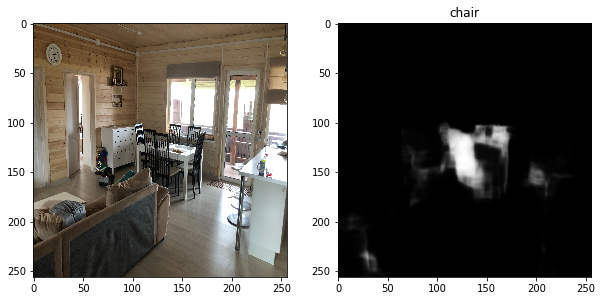

0.0024106628261506557


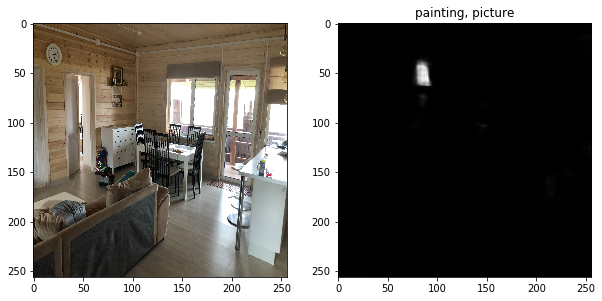

0.03332623094320297


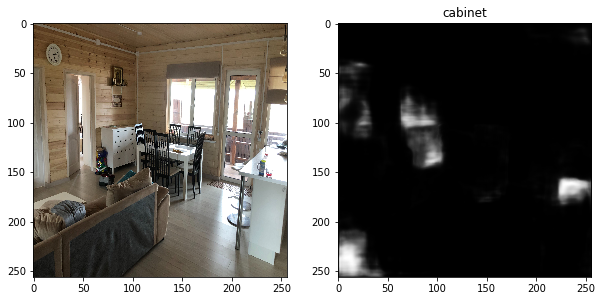

0.019214771687984467


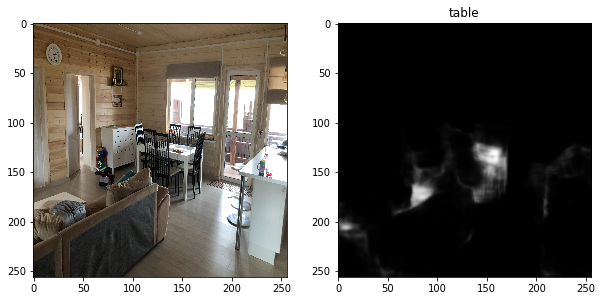

0.0015574066201224923


0.008079208433628082


0.09558455646038055


0.004395087715238333


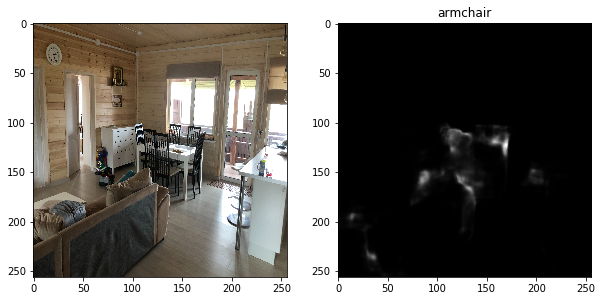

0.0008638544240966439


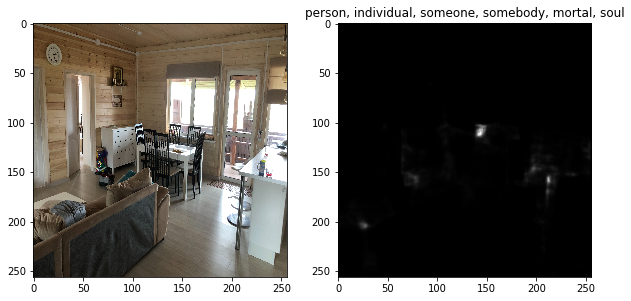

0.008144847117364407


0.0003626513935159892


0.0006600941414944828


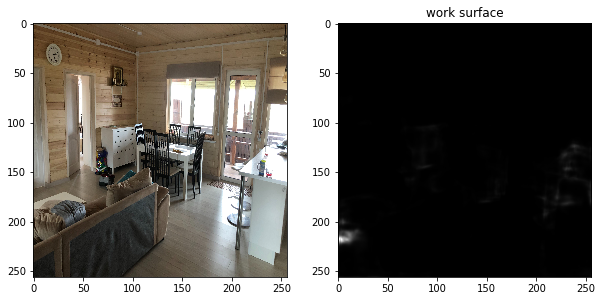

0.007874161005020142


0.00038907284033484757


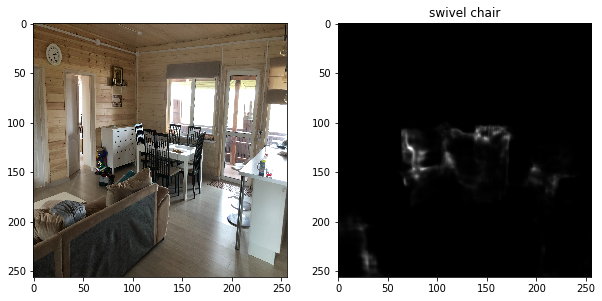

0.0007903825026005507


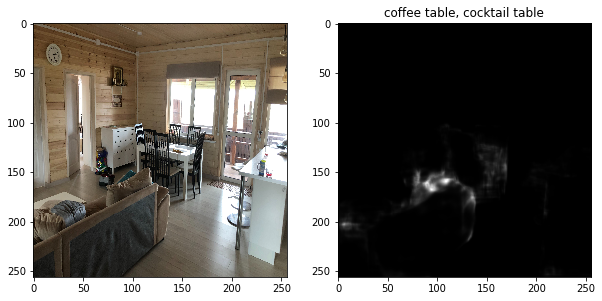

0.0008881009416654706


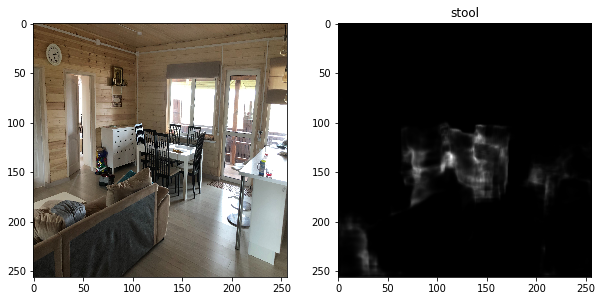

0.003537798533216119


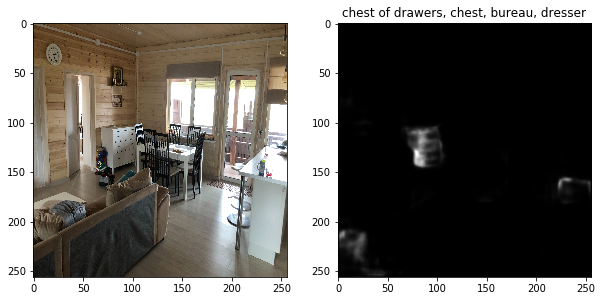

0.0007485421374440193


0.00012894977407995611


0.0015150352846831083


0.001388686359860003


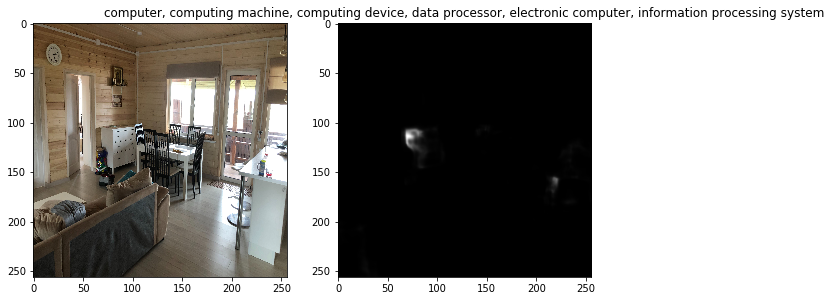

0.0002975557290483266


0.00034826635965146124


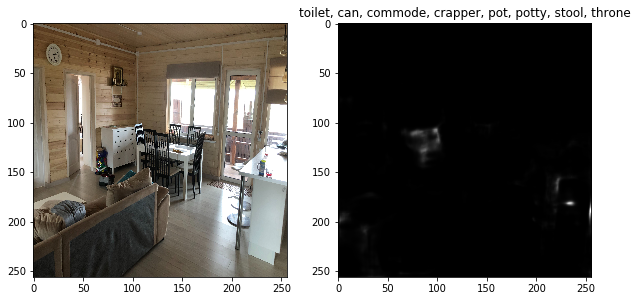

0.00047785352217033505


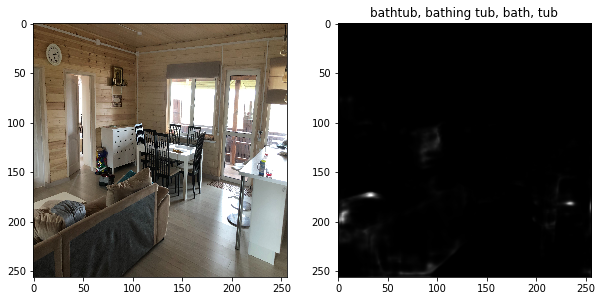

0.0043035284616053104


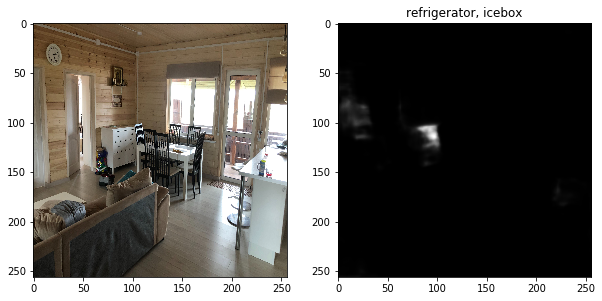

0.007453549187630415


0.0001890764106065035


0.001591410837136209


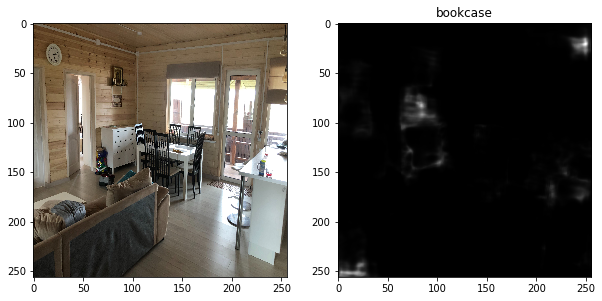

0.0004316855629440397


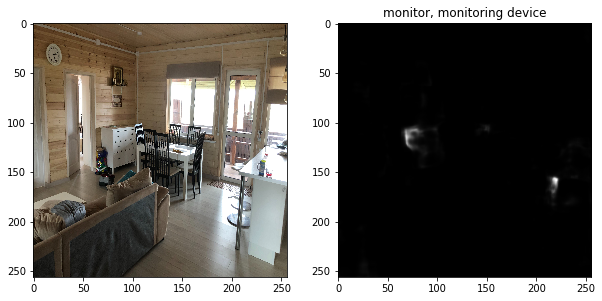

0.0016048600664362311


0.00047296355478465557


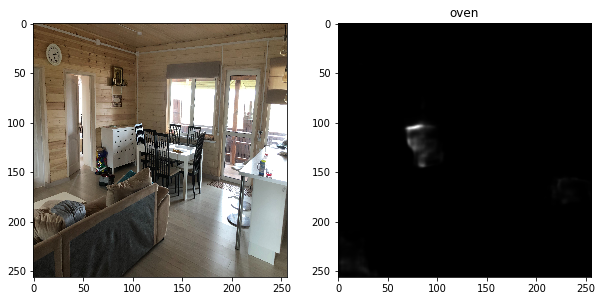

In [11]:
pred = pred_img('/home/rv/Downloads/Image from iOS.jpg')